In [87]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor
import sympy 
import pandas as pd

In [88]:

# Carga los archivos .xlsx
file1 = '../DataExperiments/WT_in_LB_data_s1.XLSX'
file2 = '../DataExperiments/different_conditions_data_s2.XLSX'

# Lee las hojas de los archivos
df1 = pd.read_excel(file1, engine='openpyxl')  # Especifica la hoja si es necesario: sheet_name='nombre_hoja'
df2 = pd.read_excel(file2, engine='openpyxl')

# Cambiar la fila 0 a la nueva cabecera
df2.columns = df2.iloc[0]  # Establecer la primera fila como nueva cabecera
df2 = df2[1:]  # Eliminar la primera fila

# Reiniciar los índices (opcional, si quieres que empiece desde 0)
df2 = df2.reset_index(drop=True)

# Muestra los DataFrames
print("Archivo 1:")
display(df1)

print("Archivo 2:")
display(df2)


Archivo 1:


,Cycle Nr.,Time [s],Temp. [°C],G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,1,0.0,30.8,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,2,678.6,30.7,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,3,1357.1,30.4,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,4,2035.7,30.2,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,5,2714.2,30.0,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,495,335199.8,30.8,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,496,335878.3,30.9,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,497,336556.8,30.8,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,498,337235.3,30.8,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


Archivo 2:


,Cycle Nr.,Time [s],Temp. [°C],A1,A2,A3,A4,A5,A6,A7,...,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11
0,1,0,30,0.0929,0.0971,0.0948,0.0961,0.0939,0.0934,0.0938,...,0.0913,0.0914,0.0924,0.0916,0.0925,0.0921,0.092,0.093,0.0927,0.093
1,2,678.6,30.5,0.0925,0.0962,0.0946,0.0953,0.0935,0.0931,0.0933,...,0.0913,0.0916,0.0926,0.092,0.0914,0.0921,0.0921,0.0931,0.0932,0.0925
2,3,1357.2,30.1,0.0926,0.0962,0.095,0.0954,0.0936,0.0932,0.0932,...,0.0916,0.0917,0.0927,0.0918,0.0917,0.0922,0.0923,0.0932,0.0932,0.0927
3,4,2035.8,30,0.0928,0.0981,0.0949,0.0956,0.0937,0.0934,0.0934,...,0.092,0.0921,0.0931,0.0922,0.0922,0.0928,0.0926,0.0936,0.0937,0.093
4,5,2714.4,30.3,0.0933,0.0985,0.0953,0.096,0.0942,0.0939,0.0938,...,0.0925,0.0927,0.0937,0.0928,0.093,0.0933,0.0933,0.0943,0.0944,0.0938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,338,228685.2,29.9,0.5954,0.6453,0.6513,0.6593,0.6599,0.6576,0.5901,...,0.0926,0.0926,0.0935,0.0924,0.0949,1.0018,0.9769,0.9848,0.9871,0.9972
338,339,229363.7,29.8,0.5937,0.6448,0.6495,0.6568,0.6572,0.6564,0.5898,...,0.0926,0.0927,0.0934,0.0926,0.0953,1.0017,0.98,0.9857,0.9868,0.9976
339,340,230042.3,29.9,0.5923,0.6429,0.6487,0.6575,0.6589,0.6572,0.5889,...,0.0925,0.0925,0.0933,0.0923,0.0947,1.0009,0.9758,0.9833,0.9846,0.9963
340,341,230720.9,30.3,0.5912,0.6419,0.6484,0.6568,0.657,0.6548,0.5888,...,0.0923,0.0924,0.0932,0.0921,0.0942,1.0004,0.9763,0.9843,0.9845,0.9981


In [89]:
df1.iloc[:, 3:]

,G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6
0,0.0922,0.0928,0.0928,0.0931,0.0928,0.0927,0.0916,0.0921,0.0911,0.0936,0.0925,0.0918,0.0929,0.0931,0.0931
1,0.0951,0.0957,0.0959,0.0959,0.0957,0.0953,0.0947,0.0951,0.0941,0.0970,0.0958,0.0951,0.0963,0.0963,0.0962
2,0.0951,0.0958,0.0957,0.0960,0.0958,0.0954,0.0947,0.0951,0.0943,0.0971,0.0959,0.0952,0.0965,0.0964,0.0963
3,0.0955,0.0962,0.0961,0.0965,0.0964,0.0958,0.0950,0.0957,0.0947,0.0975,0.0964,0.0957,0.0969,0.0969,0.0969
4,0.0960,0.0969,0.0965,0.0968,0.0968,0.0964,0.0956,0.0963,0.0953,0.0981,0.0969,0.0961,0.0974,0.0973,0.0973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,0.8186,0.8214,0.8188,0.8198,0.8221,0.8201,0.8296,0.8418,0.8292,0.4360,0.7711,0.8043,0.8181,0.8181,0.8153
495,0.8184,0.8222,0.8185,0.8178,0.8201,0.8182,0.8277,0.8379,0.8274,0.4379,0.7729,0.8038,0.8198,0.8180,0.8154
496,0.8183,0.8222,0.8169,0.8204,0.8214,0.8186,0.8287,0.8409,0.8289,0.4304,0.7719,0.8040,0.8187,0.8172,0.8154
497,0.8172,0.8211,0.8194,0.8206,0.8227,0.8201,0.8303,0.8417,0.8280,0.4321,0.7717,0.8043,0.8194,0.8173,0.8143


In [90]:
c=-1
P_exp=np.array(df1.iloc[:, 3:].drop('H1',axis=1))[:c]
T_exp=np.array(df1['Time [s]'])[:c]

T_max=max(T_exp)
T_exp=T_exp/max(T_exp)
N_exp=P_exp.shape[1]
N_exp,T_max

(14, 337235.3)

In [91]:
P_exp.shape[0]*P_exp.shape[1]

6972

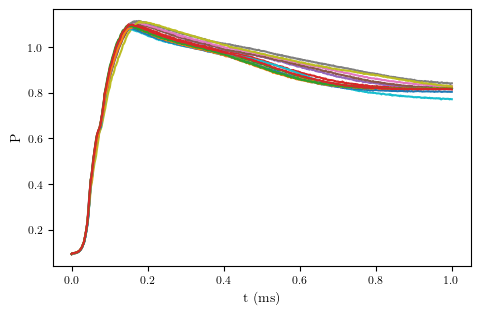

In [92]:
for i in range(N_exp):
    plt.plot(T_exp,P_exp[:, i])
plt.xlabel('t (ms)')
plt.ylabel('P ')
plt.show()

In [93]:
N_f = 300 # Number of residual point
N_d = 1000 #Number of data

P_star = P_exp.T.flatten().reshape([-1,1])
T_star = np.tile(T_exp,N_exp).reshape([-1,1])

# Doman bounds
lb = T_star.min(0)
ub = T_star.max(0) 

# Initial Condition
xx1 = T_star[::len(T_exp)]
uu1 = P_star[::len(T_exp)]

# Additional data
idx = np.random.choice(P_star.shape[0], N_d-len(uu1), replace=False)
xxd = T_star[idx]
uud = P_star[idx]

T_u_train = np.concatenate((xx1,xxd)).reshape([-1,1])
p_train = np.concatenate((uu1,uud)).reshape([-1,1])

T_f_train = lb + (ub-lb)*lhs(1, N_f)

T_u_train_tf = tf.convert_to_tensor(T_u_train, dtype=tf.float32)
p_train_tf =   tf.convert_to_tensor(p_train, dtype=tf.float32)
T_f_train_tf = tf.convert_to_tensor(T_f_train, dtype=tf.float32)
P_star_tf = tf.convert_to_tensor(P_star, dtype=tf.float32)

In [94]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 

def train_vars_total(W, b, lambda_r, lambda_b):
    return W + b + lambda_r + lambda_b

def net(t, w, b):
    p = DNN(t, w, b)
    return p

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)
    return alpha_r, alpha_b

#@tf.function(jit_compile=True)
@tf.function()
def net_f(t, W_p, b_p):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([t])
        u=net(t, W_p, b_p)
        lnp=u[:,0:1]
        r=u[:,1:2]
        p=tf.exp(lnp)

    p_t = tape1.gradient(p, t) 
    f = p_t - (r*p)
    
    return f


#@tf.function()
@tf.function()
def train_step(W_p, b_p, X_u_train_tf, p_train_tf, X_f_train_tf, lambda_r, lambda_b, opt):
    
    t_u = X_u_train_tf
    t_f = X_f_train_tf

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, lambda_r, lambda_b])
        u_nn = net(t_u, W_p, b_p) 
        lnp=u_nn[:,0:1]
        p_nn=tf.exp(lnp)
        f = net_f(t_f, W_p, b_p)

        loss_p = tf.square(lambda_b*(p_nn - p_train_tf))
        loss_f= tf.square(lambda_r*f) 
        loss =  tf.reduce_mean(loss_p) + tf.reduce_mean(loss_f)
    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)
    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
   
    return loss, tf.reduce_mean(loss_p), tf.reduce_mean(loss_f)



layers = [1, 50, 50, 2]

L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

# layers = [2, 50, 50, 1]


# W_phi = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
# b_phi = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

lambda_r, lambda_b = loss_weight(N_f, N_d)
# m = [tf.Variable(tf.ones([1,1]), dtype=tf.float32)]

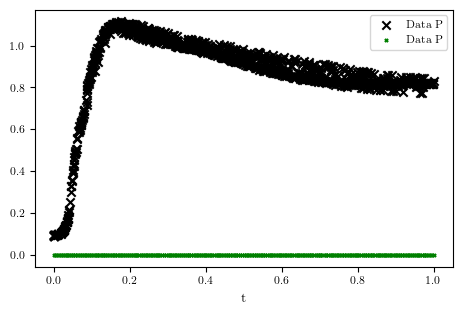

In [95]:
plt.scatter(T_u_train, p_train, marker='x', color='black',label='Data P')
plt.scatter(T_f_train_tf, np.zeros_like(T_f_train_tf), s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

In [96]:
lr = 1e-3
# Nmax = 15000
# Nmax = 30000
Nmax=2*10**5
Nmax = 150000


optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
loss_d = []
loss_fis = []

while n <= Nmax:
    loss_, loss_p, loss_f = train_step(W_p, b_p, T_u_train_tf, p_train_tf, T_f_train_tf, lambda_r, lambda_b, optimizer)
    loss.append(loss_)
    loss_d.append(loss_p)
    loss_fis.append(loss_f)


    if n % 10 == 0:
        print(f"Iteration is: {n}")
        print(f"Total loss is: {loss_}")

        print(f"Data loss is: {loss_p}")
        print(f"Physicial loss of p is: {loss_f}")

    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0
Total loss is: 173512.15625
Data loss is: 173511.390625
Physicial loss of p is: 0.7687511444091797
Iteration is: 10
Total loss is: 52560.12890625
Data loss is: 52560.0546875
Physicial loss of p is: 0.07460851967334747
Iteration is: 20
Total loss is: 60045.84765625
Data loss is: 60045.65625
Physicial loss of p is: 0.19073957204818726
Iteration is: 30
Total loss is: 52579.30859375
Data loss is: 52579.30859375
Physicial loss of p is: 0.0018896727124229074
Iteration is: 40
Total loss is: 51406.4140625
Data loss is: 51406.41015625
Physicial loss of p is: 0.0044390494003891945
Iteration is: 50
Total loss is: 51401.71875
Data loss is: 51401.68359375
Physicial loss of p is: 0.03629768639802933
Iteration is: 60
Total loss is: 50901.46484375
Data loss is: 50901.45703125
Physicial loss of p is: 0.007025304716080427
Iteration is: 70
Total loss is: 50806.87109375
Data loss is: 50806.86328125
Physicial loss of p is: 0.007586651016026735
Iteration is: 80
Total loss is: 50756.38671875


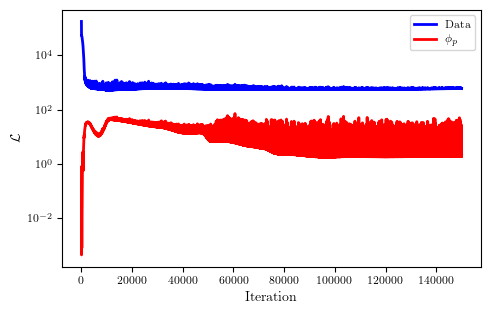

In [97]:
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_data_list = [loss_d[i].numpy() for i in range(0,Nmax)]

loss_phi_list = [loss_fis[i].numpy() for i in range(0,Nmax)]



plt.semilogy(it, np.asarray(loss_data_list), 'b-', linewidth = 2, label = 'Data')  
plt.semilogy(it, np.asarray(loss_phi_list), 'r-', linewidth = 2, label = '$\phi_p$')       


plt.xlabel('Iteration')
plt.ylabel('$\mathcal{L}$')  
plt.legend()  
# plt.savefig('figures/loss_phi.pdf')
plt.show()

In [98]:
def predict(X_star_tf, w, b):
    u_pred = net(X_star_tf, w, b)
    return u_pred

## Evaluating total function
T_star_tf = tf.convert_to_tensor(T_star[:len(T_exp)], dtype=tf.float32)    
u_pred = predict(T_star_tf, W_p, b_p)

# ## Evaluating unknown function
lnp=u_pred[:,0:1]
p=tf.exp(lnp)
r=u_pred[:,1:2]
phi_p = r*p


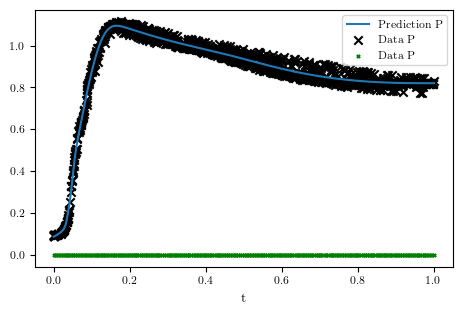

In [99]:
plt.plot(T_star_tf, p, label='Prediction P')


# for i in range(N_exp):
#     plt.plot(T_star[i*len(T_exp):(i+1)*len(T_exp)],P_star[i*len(T_exp):(i+1)*len(T_exp)],linestyle=':')

plt.scatter(T_u_train, p_train, marker='x', color='black',label='Data P')
plt.scatter(T_f_train_tf, np.zeros_like(T_f_train_tf), s=5, marker='x', color='green',label='Data P')


plt.legend()
plt.xlabel('t')
# plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

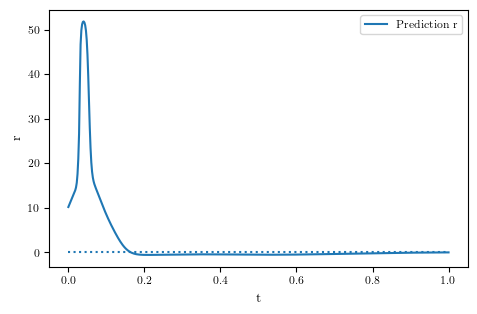

In [100]:

plt.plot(T_star_tf, r, label='Prediction r')
plt.hlines(0,0,1, linestyle=':')

# for i in range(N_exp):
#     plt.plot(T_star[i*len(T_exp):(i+1)*len(T_exp)],P_star[i*len(T_exp):(i+1)*len(T_exp)],linestyle=':')

# plt.scatter(T_u_train, p_train, marker='x', color='black',label='Data P')

plt.legend()
# plt.yscale('log')
# plt.xscale('log')


plt.xlabel('t')
plt.ylabel('r')
# plt.savefig('figures/P_phi.pdf')
plt.show()

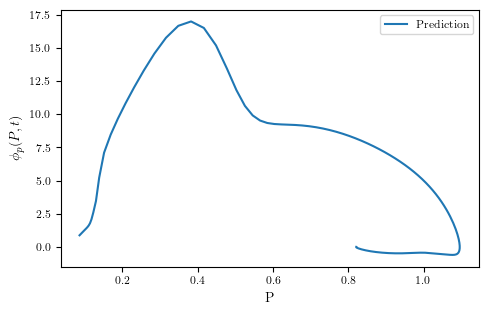

In [101]:
plt.plot(p, phi_p, label='Prediction')
# plt.plot(u_pred[:,1:2], phi_pred, label='Prediction')

# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('P')
plt.ylabel('$\phi_p(P, t)$')
# plt.savefig('figures/phi.pdf')
plt.show()

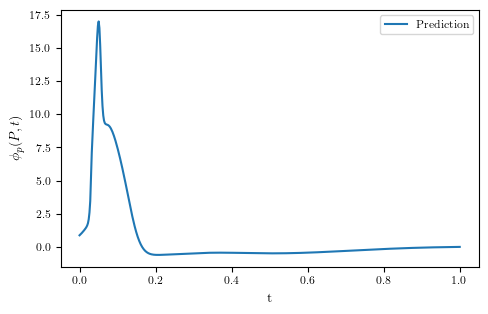

In [102]:
plt.plot(T_star_tf, phi_p, label='Prediction')
# plt.plot(u_pred[:,1:2], phi_pred, label='Prediction')

# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('t')
plt.ylabel('$\phi_p(P, t)$')
# plt.savefig('figures/phi.pdf')
plt.show()

In [103]:
Nt=10000
T_int=np.zeros(Nt)
P_int=np.zeros(Nt)
R_int=np.zeros(Nt)


dt=0.0001

T_int[0]=0
for i in range(1,Nt):
    T_int[i]=T_int[i-1]+dt
    
P_int[0]=np.array(p[0]) #Initial conditions
R_int=predict(tf.convert_to_tensor(T_int.reshape([-1,1]), dtype=tf.float32), W_p, b_p)[:,1:2]

for i in range(1,Nt):
    P_int[i]=P_int[i-1]+R_int[i-1]*P_int[i-1]*dt


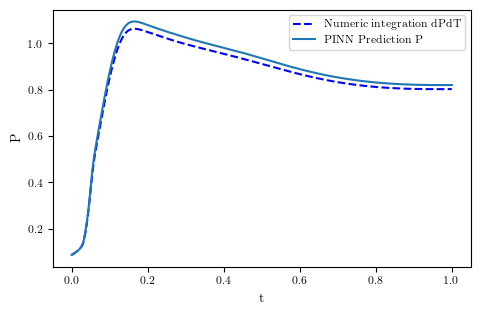

In [105]:
plt.plot(T_int, P_int, color='blue', linestyle='--', label='Numeric integration dPdT')
# plt.plot(T_int, R_int, color='blue', linestyle='--', label='Numeric integration dPdT')

# plt.plot(T_int, R_int, color='orange', linestyle='--', label='Numeric integration dSdT')


plt.plot(T_star_tf, p, label='PINN Prediction P')
# plt.plot(T_star_tf, r, label='PINN Prediction S')
plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()

# Symbolic Regresion

In [106]:
# Create and train the PySR model
model_phi = PySRRegressor(
    niterations=1000,
    binary_operators=["+", "/", "*"],
    unary_operators=["exp", "inv(x) = 1/x"],
    # unary_operators=["inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # constraints={"^": (-1, 3)},
    # constraints={"*": (1, 1)},
    # complexity_of_operators={"^": 3},
    # parsimony=0.00001,
    maxsize=45,
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    random_state=42,   # Fija la semilla
)

In [107]:
# Fit phi
# model_phi.fit(tf.concat([p,T_star_tf], axis=1), r)
model_phi.fit(T_star_tf, r)

print(model_phi)

c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:1290: UserWarning: Note: Using a large maxsize for the equation search will be exponentially slower and use significant memory.
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:1310: UserWarning: Note: Setting `random_state` without also setting `deterministic` to True and `procs` to 0 will result in non-deterministic searches. 
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 2.110e+05
Head worker occupation: 46.8%. This is high, and will prevent efficient resource usage. Increase `ncycles_per_iteration` to reduce load on head worker.
Progress: 413 / 15000 total iterations (2.753%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           7.096e+01  7.971e+00  y = exp(0.80197)
4           4.146e+01  2.687e-01  y = inv(x₀ + 0.035686)
5           4.138e+01  1.968e-03  y = inv(inv(29.382) + x₀)
6           3.987e+01  3.712e-02  y = inv(0.030261 + x₀) + -1.7224
7           3.926e+01  1.540e-02  y = exp(inv(0.26292 + x₀)) / 1.4629
8           3.578e+01  9.295e-02  y = (inv(x₀ + 0.045532) + -1.8156) * 1.9487
9           3.389e+01  5.404e-02  y = (inv(x₀ + 0.075783) + -1.8093) * exp(0.96729)
10          3.389e+01  6.438e-05  y = (-2.4121 + -2.3393) + (inv(x₀ + 0.074807) * 2.6142)
11          1.855e+01  6.027e-01  y = exp(

In [108]:
# Extraer las métricas de las ecuaciones
equations_df = model_phi.equations_
Nt = 10000
dt = 0.0001

for eq_idx in range(len(equations_df)):
    P_symb = np.zeros(Nt)
    T_symb = np.zeros(Nt)
    R_symb = np.zeros(Nt)

    # Condiciones iniciales
    P_symb[0] = np.array(p[0])  # Initial condition
    T_symb[0] = 0

    # Tiempo de simulación
    for t_idx in range(1, Nt):
        T_symb[t_idx] = T_symb[t_idx-1] + dt

    # Obtener las predicciones de la ecuación en cuestión
    R_symb = model_phi.predict(T_symb.reshape([-1, 1]), eq_idx)

    # Iterar sobre los puntos temporales para calcular la dinámica
    for t_idx in range(1, Nt):
        P_symb[t_idx] = P_symb[t_idx-1] + R_symb[t_idx-1] * P_symb[t_idx-1] * dt

    # Comparar con los datos reales y calcular el error
    # P_error = np.mean(np.abs(P_int - P_symb))
    # P_error = np.mean(np.abs(P_int - P_symb)**2)
    P_error = np.max(np.abs(P_int - P_symb))

    # P_error = np.mean(np.abs((P_int - P_symb)/P_symb))



    # Asignar el error a la columna correspondiente de equations_df
    equations_df.loc[eq_idx, 'P_error'] = P_error  # O calcula otra métrica
    if (eq_idx==0)|(eq_idx==len(equations_df)-1):
        equations_df.loc[eq_idx, 'Score_r'] = 0
        equations_df.loc[eq_idx, 'Score_p'] = 0
        equations_df.loc[eq_idx, 'Score_pr'] = 0

    


    else:
        # equations_df.loc[eq_idx, 'Score_r'] = - ((np.log(equations_df.loc[eq_idx+1, 'loss'])-np.log(equations_df.loc[eq_idx-1, 'loss'])))/(equations_df.loc[eq_idx+1, 'complexity']-equations_df.loc[eq_idx-1, 'complexity'])  # O calcula otra métrica
        # equations_df.loc[eq_idx, 'Score_p'] = - ((np.log(equations_df.loc[eq_idx+1, 'P_error'])-np.log(equations_df.loc[eq_idx-1, 'P_error'])))/(equations_df.loc[eq_idx+1, 'complexity']-equations_df.loc[eq_idx-1, 'complexity'])  # O calcula otra métrica
        # equations_df.loc[eq_idx, 'Score_pr'] = - ((np.log(equations_df.loc[eq_idx+1, 'P_error']+equations_df.loc[eq_idx+1, 'loss'])-np.log(equations_df.loc[eq_idx-1, 'P_error']+equations_df.loc[eq_idx-1, 'loss'])))/(equations_df.loc[eq_idx+1, 'complexity']-equations_df.loc[eq_idx-1, 'complexity'])  # O calcula otra métrica
        equations_df.loc[eq_idx, 'Score_r'] = - ((np.log(equations_df.loc[eq_idx, 'loss'])-np.log(equations_df.loc[eq_idx-1, 'loss'])))/(equations_df.loc[eq_idx, 'complexity']-equations_df.loc[eq_idx-1, 'complexity'])  # O calcula otra métrica
        equations_df.loc[eq_idx, 'Score_p'] = - ((np.log(equations_df.loc[eq_idx, 'P_error'])-np.log(equations_df.loc[eq_idx-1, 'P_error'])))/(equations_df.loc[eq_idx, 'complexity']-equations_df.loc[eq_idx-1, 'complexity'])  # O calcula otra métrica
        equations_df.loc[eq_idx, 'Score_pr'] = - ((np.log(equations_df.loc[eq_idx, 'P_error']+equations_df.loc[eq_idx, 'loss'])-np.log(equations_df.loc[eq_idx-1, 'P_error']+equations_df.loc[eq_idx-1, 'loss'])))/(equations_df.loc[eq_idx, 'complexity']-equations_df.loc[eq_idx-1, 'complexity'])  # O calcula otra métrica





In [109]:
equations_df

,complexity,loss,score,equation,sympy_format,lambda_format,P_error,Score_r,Score_p,Score_pr
0,1,70.963905,0.000000e+00,2.2298064,2.22980640000000,PySRFunction(X=>2.22980640000000),0.938119,0.000000e+00,0.000000,0.000000e+00
1,2,70.963900,7.045836e-08,inv(0.44854367),2.22943732546711,PySRFunction(X=>2.22943732546711),0.938126,7.045836e-08,-0.000008,-3.243542e-08
2,4,41.359610,2.699332e-01,inv(0.03286959 + x0),1/(x0 + 0.03286959),PySRFunction(X=>1/(x0 + 0.03286959)),1.935466,2.699332e-01,-0.362110,2.536328e-01
3,5,40.233654,2.760099e-02,inv(-0.9673553 + exp(x0)),1/(exp(x0) - 0.9673553),PySRFunction(X=>1/(exp(x0) - 0.9673553)),1.098922,2.760099e-02,0.566019,4.638796e-02
4,6,29.045492,3.258405e-01,exp(-11.40607 * x0) * 32.3665,exp(-11.40607*x0)*32.3665,PySRFunction(X=>exp(-11.40607*x0)*32.3665),0.684522,3.258405e-01,0.473364,3.294938e-01
5,7,28.371698,2.347119e-02,exp((-1.3478802 + exp(x0)) / -0.10099147),exp((exp(x0) - 1.3478802)/(-0.10099147)),PySRFunction(X=>exp((exp(x0) - 1.3478802)/(-0....,0.772304,2.347119e-02,-0.120658,1.990796e-02
6,8,12.594161,8.121588e-01,exp(8.01595 + (-33.065735 * x0)) * x0,x0*exp(8.01595 - 33.065735*x0),PySRFunction(X=>x0*exp(8.01595 - 33.065735*x0)),0.584257,8.121588e-01,0.279037,7.936686e-01
7,9,6.174887,7.127427e-01,exp(exp(5.589822 + (x0 * -26.0536)) * x0),exp(x0*exp(5.589822 + x0*(-26.0536))),PySRFunction(X=>exp(x0*exp(5.589822 + x0*(-26....,1.831452,7.127427e-01,-1.142523,4.983469e-01
8,11,4.206685,1.919079e-01,exp((x0 * exp((-24.744928 * x0) + 5.8492756)) ...,exp(x0*exp(5.8492756 - 24.744928*x0) - 1.3187472),PySRFunction(X=>exp(x0*exp(5.8492756 - 24.7449...,0.331420,1.919079e-01,0.854739,2.838621e-01
9,12,3.429486,2.042643e-01,-2.9280174 + exp(exp(exp(4.5384145 + (x0 * -25...,exp(exp(x0*exp(4.5384145 + x0*(-25.176239)))) ...,PySRFunction(X=>exp(exp(x0*exp(4.5384145 + x0*...,0.144325,2.042643e-01,0.831320,2.388769e-01


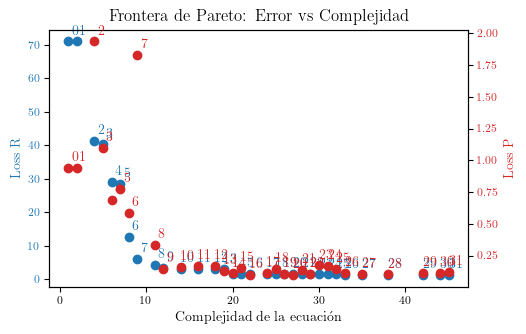

In [110]:
import matplotlib.pyplot as plt

# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores_r = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada
errores_p = equations_df['P_error']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear la figura y el eje
fig, ax1 = plt.subplots()

# Gráfico de errores_r en el eje izquierdo
color_r = 'tab:blue'
ax1.set_xlabel('Complejidad de la ecuación')
ax1.set_ylabel('Loss R', color=color_r)
ax1.scatter(complejidades, errores_r, color=color_r)
ax1.tick_params(axis='y', labelcolor=color_r)

# Añadir etiquetas de índice en cada punto (errores_r)
for i, (x, y) in enumerate(zip(complejidades, errores_r)):
    ax1.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', color=color_r)

# Crear un segundo eje y para los errores_p
ax2 = ax1.twinx()  # Crear un nuevo eje que comparte el mismo eje x
color_p = 'tab:red'
ax2.set_ylabel('Loss P', color=color_p)
ax2.scatter(complejidades, errores_p, color=color_p)
ax2.tick_params(axis='y', labelcolor=color_p)

# Añadir etiquetas de índice en cada punto (errores_p)
for i, (x, y) in enumerate(zip(complejidades, errores_p)):
    ax2.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', color=color_p)

# Añadir título
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.show()


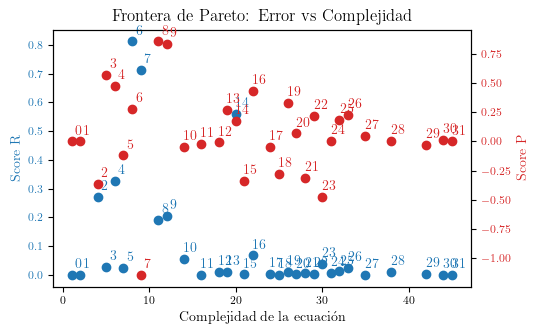

In [111]:
import matplotlib.pyplot as plt

# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
score_r = equations_df['Score_r']  # Por ejemplo, error MSE o cualquier métrica utilizada
score_p = equations_df['Score_p']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear la figura y el eje
fig, ax1 = plt.subplots()

# Gráfico de errores_r en el eje izquierdo
color_r = 'tab:blue'
ax1.set_xlabel('Complejidad de la ecuación')
ax1.set_ylabel('Score R', color=color_r)
ax1.scatter(complejidades, score_r, color=color_r)
ax1.tick_params(axis='y', labelcolor=color_r)

# Añadir etiquetas de índice en cada punto (errores_r)
for i, (x, y) in enumerate(zip(complejidades, score_r)):
    ax1.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', color=color_r)

# Crear un segundo eje y para los errores_p
ax2 = ax1.twinx()  # Crear un nuevo eje que comparte el mismo eje x
color_p = 'tab:red'
ax2.set_ylabel('Score P', color=color_p)
ax2.scatter(complejidades, score_p, color=color_p)
ax2.tick_params(axis='y', labelcolor=color_p)

# Añadir etiquetas de índice en cada punto (errores_p)
for i, (x, y) in enumerate(zip(complejidades, score_p)):
    ax2.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center', color=color_p)

# Añadir título
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.show()


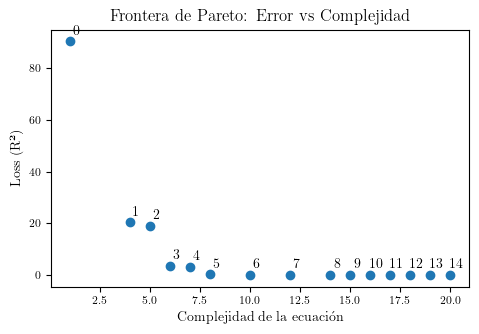

In [62]:
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.show()

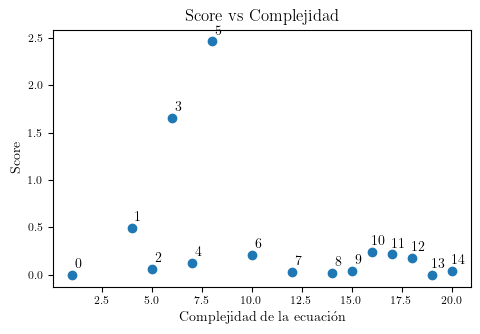

In [63]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


In [112]:
# Encontrar las tres filas con los menores valores en la columna 'P_error'
tres_menores_error_p = equations_df.nsmallest(3, 'P_error')

# Mostrar los resultados
print("Los tres menores valores de Error_P y sus índices:")
tres_menores_error_p


Los tres menores valores de Error_P y sus índices:


,complexity,loss,score,equation,sympy_format,lambda_format,P_error,Score_r,Score_p,Score_pr
20,27,1.553830,0.001572,(inv(0.17780726 + ((x0 + x0) / (-0.19701919 + ...,-0.731714205894719 - 0.54249316 + 1/((x0 + x0)...,PySRFunction(X=>-0.731714205894719 - 0.5424931...,0.097204,0.001572,0.067881,0.005600
16,22,1.582947,0.067599,inv(0.17780726 + ((x0 + x0) / (-0.19701919 + (...,-1.023041 + 1/((x0 + x0)/(x0*(x0 + 1.0414494/(...,PySRFunction(X=>-1.023041 + 1/((x0 + x0)/(x0*(...,0.099412,0.067599,0.430927,0.093157
28,38,1.376634,0.009863,(inv(0.1786343 + ((x0 + x0) / (((1.1621641 / (...,x0*(x0 - 1.0465028)/((exp(-2.2732167)*exp(x0))...,PySRFunction(X=>x0*(x0 - 1.0465028)/((exp(-2.2...,0.100571,0.009863,0.007010,0.009670


In [113]:
equations_df.nsmallest(1, 'P_error').index[0]


20

In [138]:
choser=equations_df.nsmallest(1, 'P_error').index[0]
choser=14
expr=model_phi.sympy(choser)
expr
sympy.expand(expr)

-0.83701116 + 1/(2*x0/(1.0414494*x0/(x0 + x0 - 0.21508281) - 0.19701919) + 0.17780726)

In [139]:
sympy.factor(expr)


-0.83701116*(1.0*x0**2 - 0.272132698989378*x0 - 0.0107731077377432)/(1.0*x0**2 - 0.0787628101099987*x0 + 0.00188366526428099)

In [140]:
sympy.simplify(expr)


(-3.34804464*x0**2 + 0.911112424220119*x0 + 0.0360688456174938)/(4.0*x0**2 - 0.315051240439995*x0 + 0.00753466105712396)

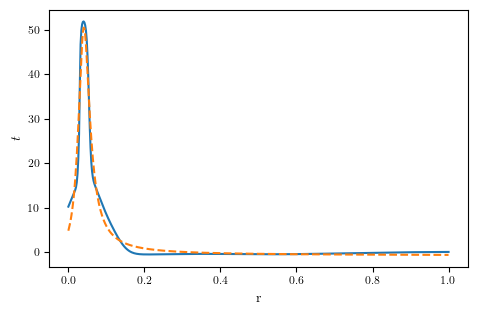

In [141]:
symb1=model_phi.predict(T_star_tf,choser)
# symb1=model_phi.predict(tf.concat([p,T_star_tf], axis=1),choser)

plt.plot(T_star_tf, r, label='PINN prediction')
plt.plot(T_star_tf, symb1, linestyle='--', label='Symbolic regresion')

plt.xlabel('r')
plt.ylabel('$t$')
plt.show()

In [142]:
Nt=10000
P_symb=np.zeros(Nt)
T_symb=np.zeros(Nt)
R_symb=np.zeros(Nt)

dt=0.0001

P_symb[0]=np.array(p[0]) #Initial conditions
# S_symb[0]=np.array(tf.exp(u_pred[0,1:2])) #Initial conditions
T_symb[0]=0
for i in range(1,Nt):
    T_symb[i]=T_symb[i-1]+dt

R_symb=model_phi.predict(T_symb.reshape([-1,1]),choser)
for i in range(1,Nt):
    P_symb[i]=P_symb[i-1]+R_symb[i-1]*P_symb[i-1]*dt
    T_symb[i]=T_symb[i-1]+dt

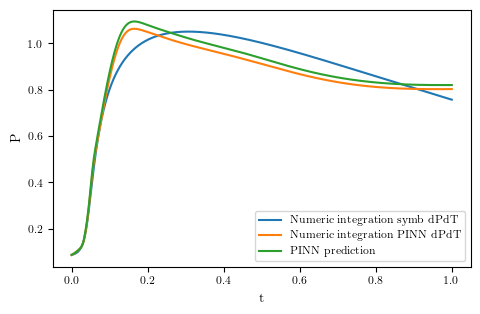

In [143]:
plt.plot(T_symb, P_symb, label='Numeric integration symb dPdT')
plt.plot(T_int, P_int, label='Numeric integration PINN dPdT')
plt.plot(T_star_tf, p, label='PINN prediction')
plt.xlabel('t')
plt.ylabel('P')
plt.legend()
plt.show()